This exercise is about predicting 'popularity' of post on NYTimes website.
A 'popular' defined as a post with 20 or more comments.
The data consists of 8402 entries altogether for training and testings sets.
The fields are:
- NewsDesk = the New York Times desk that produced the story (Business, Culture, Foreign, etc.)
- SectionName = the section the article appeared in (Opinion, Arts, Technology, etc.)
- SubsectionName = the subsection the article appeared in (Education, Small Business, Room for Debate, etc.)
- Headline = the title of the article
- Snippet = a small portion of the article text
- Abstract = a summary of the blog article, written by the New York Times
- WordCount = the number of words in the article
- PubDate = the publication date
- UniqueID = a unique identifier for each article

The plan is to use Pyhon's sklearn package to build several classifiers (Random Forest, Gradient Boosting Classifier, Logistic Regression) while exploring effectiveness of different approaches to feature selection and model regularization.

The first attempt, described in this post, will build naïve Random Forest classifier built upon the following features:
- NewsDesk, SectionName, SubsectionName
- Bag of uni- and bi-grams extracted from Headline and Abstract
- Part of day (morning, afternoon, evening etc) and day of week extracted from PubDate.

The approach is 'naïve' because no feature filtering whatsoever is employed: just about 3'500 features are thrown at Random Forest without tuning hyperparameters, the model is trained on ~ 5200 cases, and then checked on 1'307 validation held-out set.

The performance of this model will be used later as a benchmark when more sophisticated models are developed.

The main purpose of the project is to:
- find model with best cross-validated AUC score on train set
- that generalizes well to held-out set
- with no humane intervention in the process of feature creation, i.e. pure unsupervised feature creation, feature selection, and model selection.

## Load Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
seed = 1

In [3]:
train = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTrain.csv')
test = pd.read_csv('/home/sergey/R_Analyttics_Edge_MITx/kaggle/NYTimesBlogTest.csv')

In [4]:
combo = pd.merge(train, test, how='outer')
combo = combo.drop('Popular', axis=1)
y = train['Popular']

In [5]:
print(train.shape)
print(y.shape)
print(test.shape)
print(combo.shape)

(6532, 10)
(6532,)
(1870, 9)
(8402, 9)


In [6]:
combo.head(3)

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,UniqueID
0,Business,Crosswords/Games,NaN,More School Daze,A puzzle from Ethan Cooper that reminds me tha...,A puzzle from Ethan Cooper that reminds me tha...,508,2014-09-01 22:00:09,1
1,Culture,Arts,NaN,New 96-Page Murakami Work Coming in December,The Strange Library will arrive just three and...,The Strange Library will arrive just three and...,285,2014-09-01 21:14:07,2
2,Business,Business Day,Dealbook,Public Pension Funds Stay Mum on Corporate Expats,Public pension funds have major stakes in Amer...,Public pension funds have major stakes in Amer...,1211,2014-09-01 21:05:36,3


## Data preprocessing:
- NaN --> "empty"
- WordCount --> log(Wordcount)
- PubDate --> Weekday and time
- Time --> bins 

In [7]:
combo_clean = combo.fillna('empty')

WordCount needs to be log-transformed because the distribution of counts is heavily right-skewed.

In [8]:
combo_clean['LogWC'] = np.log(.1+ combo_clean['WordCount'])

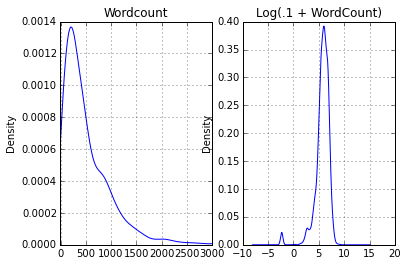

In [9]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
combo_clean['WordCount'].plot(kind='kde', title='Wordcount', xlim=[-10,3000])
plt.subplot(1,2,2)
combo_clean['LogWC'].plot(kind='kde', title='Log(.1 + WordCount)')
plt.show()

In [10]:
combo_clean['PubDate'][0]

'2014-09-01 22:00:09'

In [11]:
import datetime as dt
combo_clean['date'] = combo_clean['PubDate'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%A')
)
combo_clean['hour'] = combo_clean['PubDate'].apply(
    lambda x: int(dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%H'))
)
combo_clean[['PubDate','date','hour']][1:5]

,PubDate,date,hour
1,2014-09-01 21:14:07,Monday,21
2,2014-09-01 21:05:36,Monday,21
3,2014-09-01 20:43:34,Monday,20
4,2014-09-01 18:58:51,Monday,18


In [12]:
bins = np.linspace(0,24,5)
labels = ['night', 'morning', 'afternoon', 'evening']
combo_clean['hour_bins'] = pd.cut(combo_clean['hour'], bins=bins, labels=labels)

In [13]:
combo_clean.drop(['hour', 'WordCount', 'PubDate'], axis=1, inplace=True)

In [14]:
combo_clean.head(3)

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,UniqueID,LogWC,date,hour_bins
0,Business,Crosswords/Games,empty,More School Daze,A puzzle from Ethan Cooper that reminds me tha...,A puzzle from Ethan Cooper that reminds me tha...,1,6.230678,Monday,evening
1,Culture,Arts,empty,New 96-Page Murakami Work Coming in December,The Strange Library will arrive just three and...,The Strange Library will arrive just three and...,2,5.652840,Monday,evening
2,Business,Business Day,Dealbook,Public Pension Funds Stay Mum on Corporate Expats,Public pension funds have major stakes in Amer...,Public pension funds have major stakes in Amer...,3,7.099284,Monday,evening


## Feature creation
- Dummify categorical features
- Make bag of words out of Headline and Abstract

In [15]:
categorical_dummies = pd.get_dummies(combo_clean[['NewsDesk','SectionName','SubsectionName','date', 'hour_bins']])
categorical_dummies.shape

(8402, 49)

In [16]:
import sklearn.feature_extraction.text as txt

In [17]:
tfidf = txt.TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1, 2),)
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
bwHeadline       = (tfidf.fit_transform(combo_clean['Headline'])).todense()
bwHeadline_names = np.asarray(tfidf.get_feature_names())
bwHeadline_names = np.core.defchararray.add('H_', bwHeadline_names)
print(bwHeadline.shape)
print(bwHeadline_names.shape)

(8402, 943)
(943,)


In [19]:
bwAbstract       = (tfidf.fit_transform(combo_clean['Abstract'])).todense()
bwAbstract_names = np.asarray(tfidf.get_feature_names())
bwAbstract_names = np.core.defchararray.add('A_', bwAbstract_names)
print(bwAbstract.shape)
print(bwAbstract_names.shape)

(8402, 2480)
(2480,)


Put everything togeher

In [20]:
data = np.concatenate((categorical_dummies, bwHeadline, bwAbstract), axis=1)
data.shape

(8402, 3472)

In [44]:
feature_names = np.concatenate((categorical_dummies.columns, bwHeadline_names, bwAbstract_names), axis=0)
feature_names.shape

(3472,)

Make 5 sets:
- data_test : this is where predictions are made and submitted
- data_train: this is where the hyperparameters are tuned via CV (80% ofthe original train set)
- y_train   : labels for data_train
- data_val  : this is data unseen for trained model to check generalization ability (20%)
- y_val     : labels for data_val

In [104]:
data_train = data[: train.shape[0],:]
data_test  = data[train.shape[0]:,:]

In [105]:
import sklearn.cross_validation as cv

In [106]:
data_train, data_val, y_train, y_val = cv.train_test_split(data_train, y, test_size=.2, random_state=seed)

In [115]:
print(data_train.shape)
print(data_val.shape)
print(y_val.shape)

(5225, 3472)
(1307, 3472)
(1307,)


## Feature importance

The idea is to grow many trees and average feature importance over those trees. To further guard against overfitting, let's use sklearn.ExtraTreesClassifier, which is a modified version of Random Forest. ExtraTreesClassifier, in addition to randomly selecting features at each split, randomizes samples over which it trains model. 

In [107]:
import sklearn.ensemble as ens
rf = ens.ExtraTreesClassifier(n_estimators=3000, random_state=seed, n_jobs=-1, bootstrap=True, class_weight='auto')

In [108]:
rf.fit(data_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='auto', criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [75]:
importance = np.mean([tree.feature_importances_ for tree in rf.estimators_],axis=0)
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
ind = np.argsort(importance)[-30:]

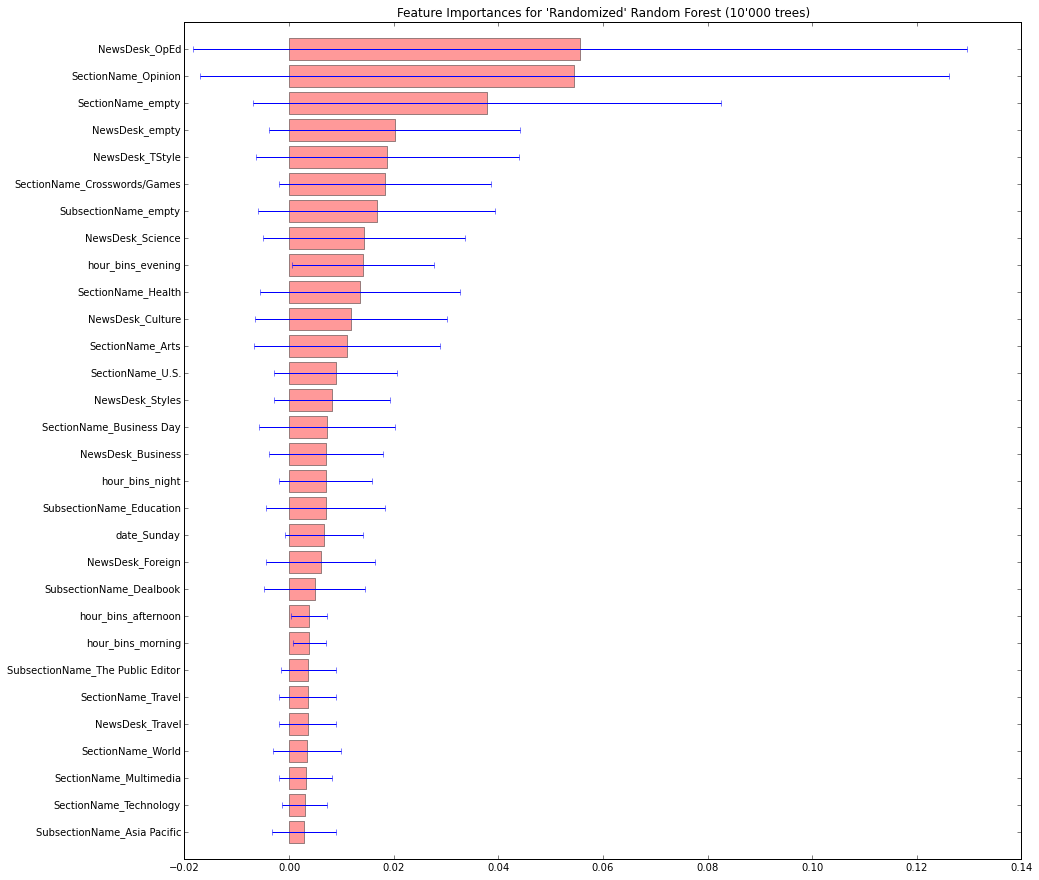

In [76]:
plt.figure(figsize=(15,15))
plt.title("Feature Importances for 'Randomized' Random Forest (10'000 trees)")
plt.barh(range(30),importance[ind],
       color="r", xerr=std[ind], alpha=0.4, align="center")
plt.yticks(range(30), feature_names[ind])
plt.ylim([-1, len(ind)])
plt.show()

The conclusions so far are not that reassuring: feature importance averaged over 3'000 trees grown tells that there are few strong, consistent predictors. From this graph, the only significant predictor is time when the post is published, which makes sense.

## Learning curves

Learning curves allow to distinguish between models dominated by strong bias or strong variance, thus laying down a roadmap whether the model should be relaxed (made more flexible) or, to the contrary, regularized (made more rigid).

In [78]:
import sklearn.learning_curve as lc

In [94]:
train_size, train_scores, test_scores = lc.learning_curve(rf, data_train, y_train, 
                                                          train_sizes=np.linspace(0.1,1.0,5),
                                                          cv=10, scoring='roc_auc',
                                                          exploit_incremental_learning=False, n_jobs=-1)

In [99]:
train_size

array([ 470, 1528, 2586, 3644, 4702])

In [95]:
mean_train  = train_scores.mean(axis=1)
sd_train    = train_scores.std(axis=1)
upper_train = mean_train + sd_train
lower_train = mean_train - sd_train

In [96]:
mean_test   = test_scores.mean(axis=1)
sd_test     = test_scores.std(axis=1)
upper_test  = mean_test + sd_test
lower_test  = mean_test - sd_test

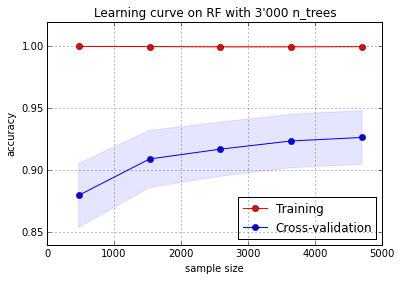

In [97]:
plt.plot(train_size, mean_train,'ro-', label='Training')
plt.fill_between(train_size, upper_train, lower_train, alpha=0.1, color='r')
plt.plot(train_size, mean_test,'bo-', label='Cross-validation')
plt.fill_between(train_size, upper_test, lower_test, alpha=0.1, color='b')
plt.title("Learning curve on RF with 3'000 n_trees")
plt.grid()
plt.xlabel('sample size') 
plt.ylabel('accuracy')
plt.legend(loc='lower right', numpoints= 1)
plt.show()

The behavior shown in the graph:
- perfect 'memorizing' train set
- quickly learning how to predict a held-out validation set
is characteristic for high-variance model, which is not surprising for a model with ~5'000 cases trained on ~3'000 features. Most probably such a model will fit to noise and generalization may be sub par.

Thus, the plan for model improvement includes:
- reducing # of features either through filtering for most important variables or penalizing flexibility (l1 or l2 penalties).
- further feature engineering 
- trying other models, e.g. Logistic Regression or Gradient Boosted Trees, which are less sensitive to noise

## Model validation on held-out set

In [112]:
import sklearn.metrics as mts

In [124]:
print('AUC on held-out sample is %0.5f' % mts.roc_auc_score(y_val, rf.predict_proba(data_val)[:,1]))

AUC on held-out sample is 0.92616


The resulting AUC of .92 is very good, provided it will generalize well. Let's see what model improvements are possible.